# Исследование активности клиентов интернет-магазина «В один клик»

****Описание проекта****

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

Мы будем использовать следующий подход к решению задачи:
1. Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
2. Нужно собрать данные по клиентам по следующим группам:
    - Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
    - Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
    - Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
    - Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.
3. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
4. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
5. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

## Шаг 1. Загрузка данных

In [1]:
#!pip install phik

In [2]:
#!pip install shap 

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from math import sqrt
import plotly.express as px
from scipy.stats import binom, poisson
from math import factorial

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler
)

from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import phik
import shap

Загрузим наши данные.

In [5]:
try:
    market_file = pd.read_csv('C:/Users/almuc/Downloads/market_file.csv', decimal = ',')
    market_money = pd.read_csv('C:/Users/almuc/Downloads/market_money.csv', decimal = ',')
    market_time = pd.read_csv('C:/Users/almuc/Downloads/market_time.csv', decimal = ',')
    money = pd.read_csv('C:/Users/almuc/Downloads/money.csv', sep=';', decimal = ',')
except:
    market_file = pd.read_csv('/datasets/market_file.csv', decimal = ',')
    market_money = pd.read_csv('/datasets/market_money.csv', decimal = ',')
    market_time = pd.read_csv('/datasets/market_time.csv', decimal = ',')
    money = pd.read_csv('/datasets/money.csv', sep=';', decimal = ',')

Попробовал, выдает ошибку: AttributeError: 'tuple' object has no attribute 'head'. Прошу объяснить, что неверно.

In [6]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Проверим сразу ошибки в заполнении данных.

In [7]:
market_file['Покупательская активность'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

In [8]:
market_file['Тип сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

Здесь мы видим ошибку в слове стандартт, проведем замену данных.

In [9]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].str.replace('тт', 'т')

In [10]:
market_file = market_file.rename (columns= {'Покупательская активность': 'Покупательская_активность'})

In [11]:
market_file['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

Ошибка устранена.

In [12]:
market_file['Разрешить сообщать'].unique()

array(['да', 'нет'], dtype=object)

In [13]:
market_file['Популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

И приведем названия столбцов к нижнему регистру.

In [14]:
market_file.columns = map(str.lower, market_file.columns)

In [15]:
market_file.head()

,id,покупательская_активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [16]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   id                                   1300 non-null   int64 
 1   покупательская_активность            1300 non-null   object
 2   тип сервиса                          1300 non-null   object
 3   разрешить сообщать                   1300 non-null   object
 4   маркет_актив_6_мес                   1300 non-null   object
 5   маркет_актив_тек_мес                 1300 non-null   int64 
 6   длительность                         1300 non-null   int64 
 7   акционные_покупки                    1300 non-null   object
 8   популярная_категория                 1300 non-null   object
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64 
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64 
 11  ошибка_сервиса                       1300 n

В первом датафрейме мы видим данные о покупателях, в таблице находится 1300 строк и 13 столбцов. В заполнении были ошибки, которы устранены. Также названия столбцов приведены к нижнему регистру. Пропусков в данных нет.

In [17]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Проверяем ошибки заполнения данных.

In [18]:
market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Вроде "препредыдущий" написано неверно, да и очень в глаза бросается. Поэтому проведем замену на "предпредыдущий".

In [19]:
market_money['Период'] = market_money['Период'].str.replace('препредыдущий_месяц', 'предпредыдущий_месяц')

И приведем названия столбцов к нижнему регистру.

In [20]:
market_money.columns = map(str.lower, market_money.columns)

In [21]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       3900 non-null   int64 
 1   период   3900 non-null   object
 2   выручка  3900 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.5+ KB


В таблице 3900 строк и 3 столбца. Данная таблица является основной, т.к. содержит информацию о покупках клиентов. Пропуски значений отсутствуют.

In [22]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Проверим верность заполнения данных.

In [23]:
market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

Исправим ошибку в слове предыдущий.

In [24]:
market_time['Период'] = market_time['Период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')

И приведем названия столбцов к нижнему регистру.

In [25]:
market_time.columns = map(str.lower, market_time.columns)

In [26]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


В таблице с временем 2600 строк и 3 столбца. Пропусков нет.

In [27]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Приведем названия столбцов к нижнему регистру.

In [28]:
money.columns = map(str.lower, money.columns)

In [29]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


В таблице 1300 строк и 2 столбца. Пропусков нет.

## Шаг 2. Предобработка данных

Проведем проверку данных на наличие пропусков и дубликатов.

**Считаем количество пропущенных значений**

In [30]:
market_file.isna().sum()

id                                     0
покупательская_активность              0
тип сервиса                            0
разрешить сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

In [31]:
market_money.isna().sum()

id         0
период     0
выручка    0
dtype: int64

In [32]:
market_time.isna().sum()

id        0
период    0
минут     0
dtype: int64

In [33]:
money.isna().sum()

id         0
прибыль    0
dtype: int64

Пропусков в данных нет.

**Посчитаем наличие дубликатов.**

In [34]:
print('Количество явных дубликатов в данных с клиентами', market_file.duplicated().sum())

Количество явных дубликатов в данных с клиентами 0


In [35]:
print('Количество явных дубликатов в данных с покупками', market_money.duplicated().sum())

Количество явных дубликатов в данных с покупками 0


In [36]:
print('Количество явных дубликатов в данных с временем на сайте', market_time.duplicated().sum())

Количество явных дубликатов в данных с временем на сайте 0


In [37]:
print('Количество явных дубликатов в данных с прибылью', money.duplicated().sum())

Количество явных дубликатов в данных с прибылью 0


Дубликаты не выявлены.

**Проверим типы данных**

In [38]:
market_file.head()

,id,покупательская_активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [39]:
market_file.dtypes

id                                      int64
покупательская_активность              object
тип сервиса                            object
разрешить сообщать                     object
маркет_актив_6_мес                     object
маркет_актив_тек_мес                    int64
длительность                            int64
акционные_покупки                      object
популярная_категория                   object
средний_просмотр_категорий_за_визит     int64
неоплаченные_продукты_штук_квартал      int64
ошибка_сервиса                          int64
страниц_за_визит                        int64
dtype: object

Заменим тип данных в столбцах "маркет_актив_6_мес" и "акционные_покупки" на формат float32.

In [40]:
market_file['маркет_актив_6_мес'] = market_file['маркет_актив_6_мес'].astype('float32')
market_file['акционные_покупки'] = market_file['акционные_покупки'].astype('float32')

In [41]:
market_file.dtypes

id                                       int64
покупательская_активность               object
тип сервиса                             object
разрешить сообщать                      object
маркет_актив_6_мес                     float32
маркет_актив_тек_мес                     int64
длительность                             int64
акционные_покупки                      float32
популярная_категория                    object
средний_просмотр_категорий_за_визит      int64
неоплаченные_продукты_штук_квартал       int64
ошибка_сервиса                           int64
страниц_за_визит                         int64
dtype: object

Данные заменены, приступим к следующим таблицам.

In [42]:
market_money.head()

,id,период,выручка
0,215348,предпредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,предпредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [43]:
market_money.dtypes

id          int64
период     object
выручка    object
dtype: object

Заменим тип данных в столбце "выручка" на формат float32.

In [44]:
market_money['выручка'] = market_money['выручка'].astype('float32')

In [45]:
market_money.dtypes

id           int64
период      object
выручка    float32
dtype: object

Тип данных изменен.

In [46]:
market_time.head()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


In [47]:
market_time.dtypes

id         int64
период    object
минут      int64
dtype: object

Тут ничего менять не нужно.

In [48]:
money.head()

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [49]:
money.dtypes

id           int64
прибыль    float64
dtype: object

И здесь типы данных верные.

По итогам предобработки данных можно сделать следующие выводы:
1. Явных дубликатов в предоставленных данных нет.
2. Была произведена замена тип данных на float32. Данная проблема образовалась из-за того, что данные были подготовлены некорректно, и использовалась запятая вместо точки.

## Шаг 3. Исследовательский анализ данных

Построим таблицы со статистическими данными.

**1. Данные о покупателях**

In [50]:
market_file.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014813,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


In [51]:
market_file_list = [
    'маркет_актив_6_мес', 
    'маркет_актив_тек_мес', 
    'длительность', 
    'акционные_покупки', 
    'средний_просмотр_категорий_за_визит', 
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'страниц_за_визит'
]

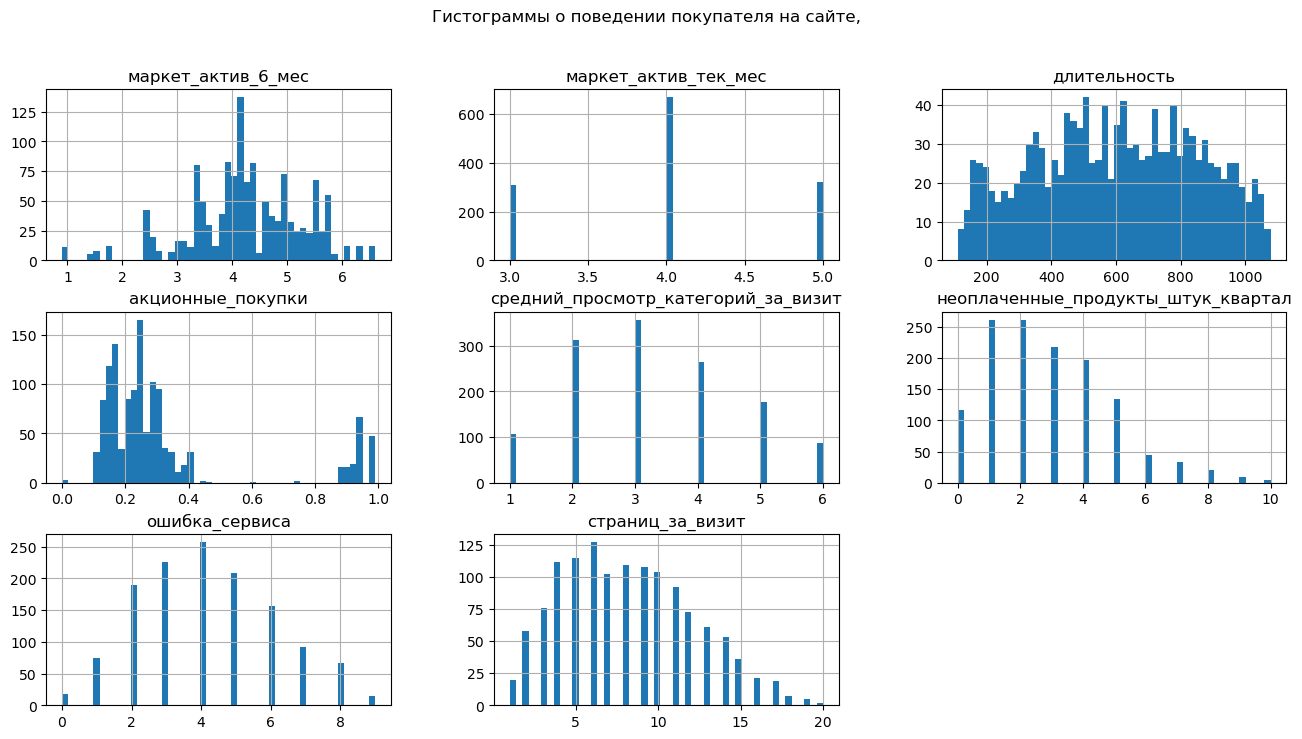

In [52]:
axs = market_file[market_file_list].hist(figsize=(16, 8), bins=50)
plt.suptitle('Гистограммы о поведении покупателя на сайте,');

Данные выглядят нормально, оставим как есть.

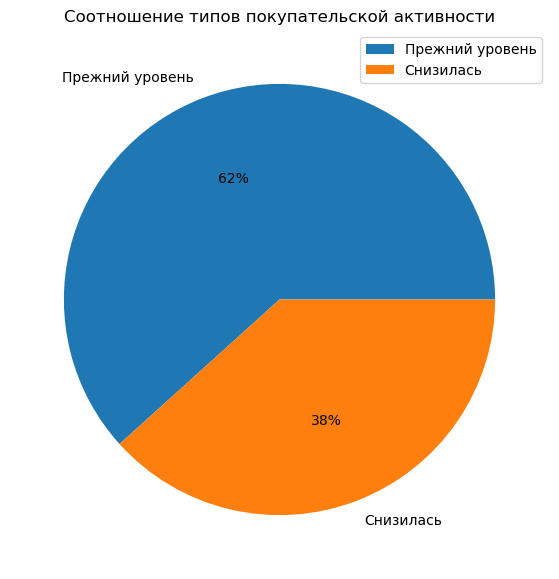

In [53]:
market_file.pivot_table(index='покупательская_активность',values='id',aggfunc='count') \
  .plot.pie(y='id', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Соотношение типов покупательской активности")
plt.show()

У 38 % пользователей снизилась покупательская активность. Довольно большой %, стоит задуматься над привлечением клиентов.

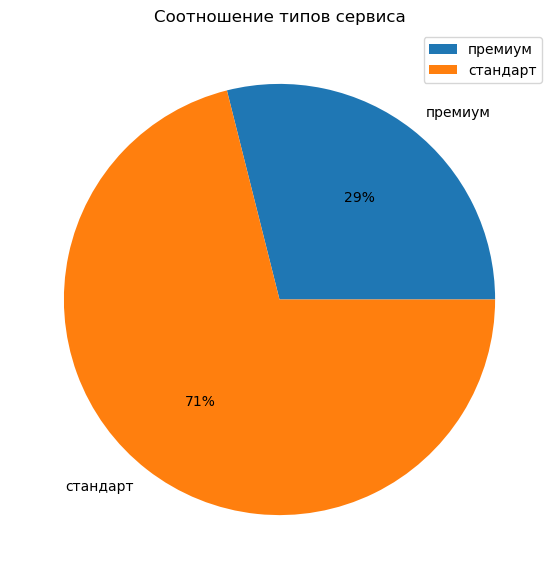

In [54]:
market_file.pivot_table(index='тип сервиса',values='id',aggfunc='count') \
  .plot.pie(y='id', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Соотношение типов сервиса")
plt.show()

Как и ожидалось большинство, а именно 71 % пользуются сервисом "Стандарт". Покупатели не стремятся приобрести подписку премиум.

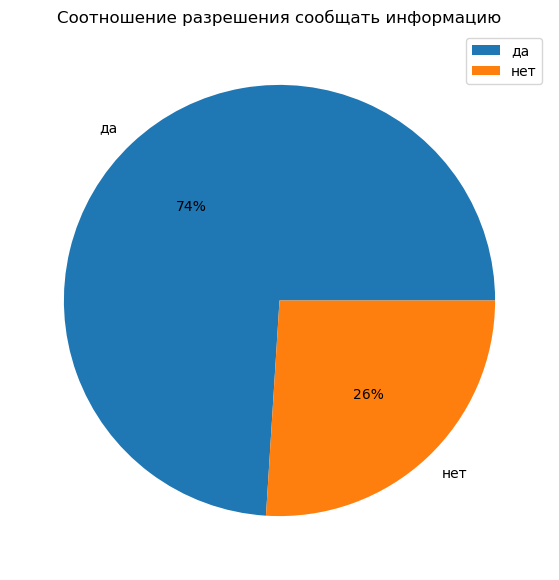

In [55]:
market_file.pivot_table(index='разрешить сообщать',values='id',aggfunc='count') \
  .plot.pie(y='id', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Соотношение разрешения сообщать информацию")
plt.show()

3/4 от покупателей разрешили уведомлять их, это говорит о том, что им все же интересны акции платформы.

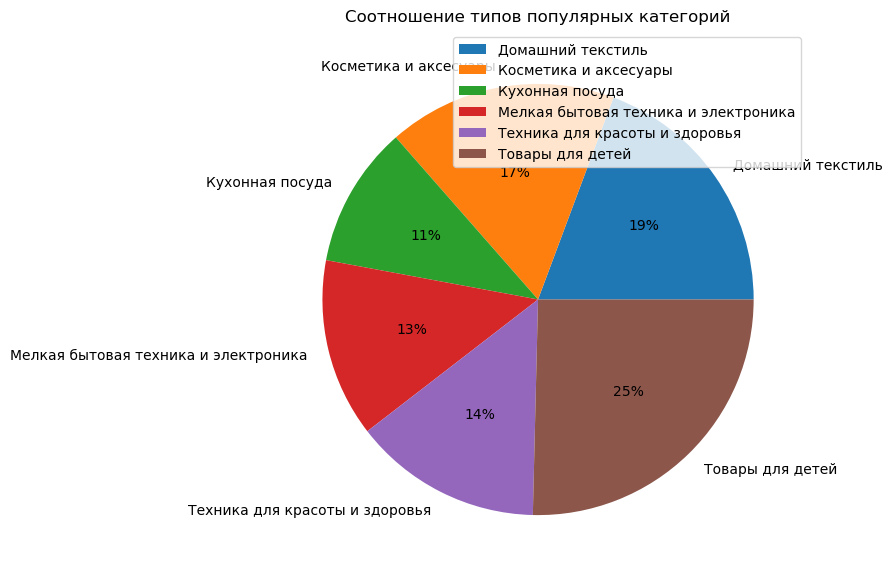

In [56]:
market_file.pivot_table(index='популярная_категория',values='id',aggfunc='count') \
  .plot.pie(y='id', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Соотношение типов популярных категорий")
plt.show()

25 % занимает категория "Товары для детей", "Домашний текстиль" 19 %, "Косметика и аксессуары" 17 %. Да и остальные категории отностятся к категории быта. Могу предположить, что основной контингент пользователей это молодые женщины с детьми. Стоит подумать над расширением ассортимента для данной категории людей.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
 
👍 Да, хорошее предположение. В целом, выглядит как обычный маркетплейс.
</div>  


**2. Данные о продажах.**

In [57]:
market_money.describe()

,id,выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696289
std,375.325686,1777.703613
min,215348.000000,0.000000
25%,215672.750000,4590.150146
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.203125


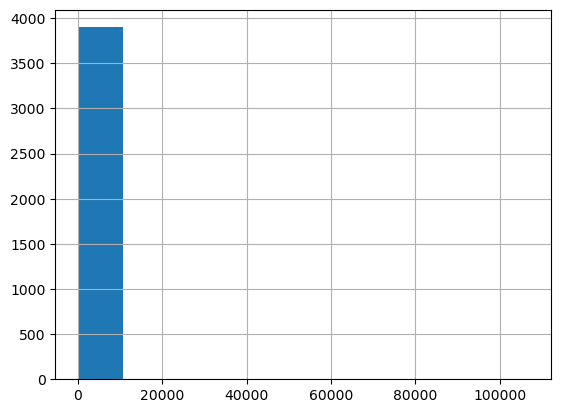

In [58]:
market_money['выручка'].hist();

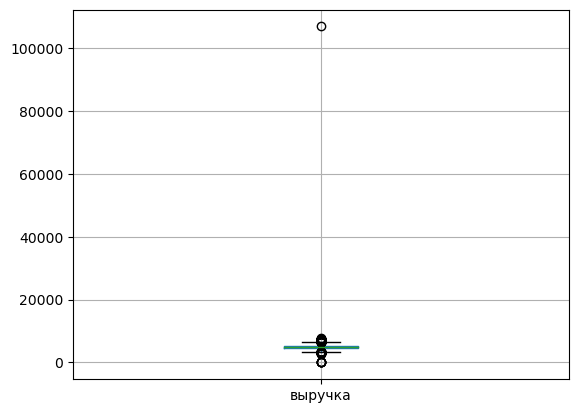

In [59]:
market_money.boxplot('выручка');

Один покупатель сильно выбивается из объемов покупок. За месяц более 100 тыс. руб. Посмотрим на этого покупателя.

In [60]:
record_money = market_money[market_money['выручка'] >= 20000]
record_money.head()

,id,период,выручка
98,215380,текущий_месяц,106862.203125


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
 
👍 Верно.
</div>  


Также имеются нулевые покупки.

In [61]:
zero_money = market_money[market_money['выручка'] <= 1000]
zero_money

,id,период,выручка
0,215348,предпредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,предпредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,предпредыдущий_месяц,0.0


За месяц более 106 тысяч рублей. Вполне возможно, что покупатель такой есть, но при прогнозировании эти данные будут сильно смещать наши данные. Также нулевые покупки, думаю это ошибки данных. Поэтому этих покупателей я удаляю.

In [62]:
market_money = market_money.drop(98)
market_money = market_money[market_money['выручка'] >= 1000]

In [63]:
market_money.describe()

,id,выручка
count,3893.000000,3893.000000
mean,215998.649371,5007.282715
std,374.681667,679.724304
min,215348.000000,2758.699951
25%,215674.000000,4592.000000
50%,215999.000000,4959.000000
75%,216323.000000,5363.000000
max,216647.000000,7799.399902


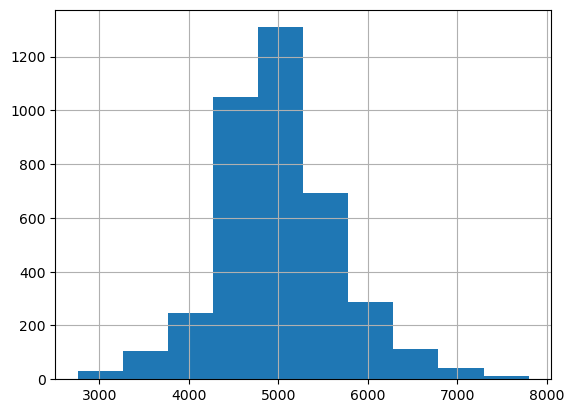

In [64]:
market_money['выручка'].hist();

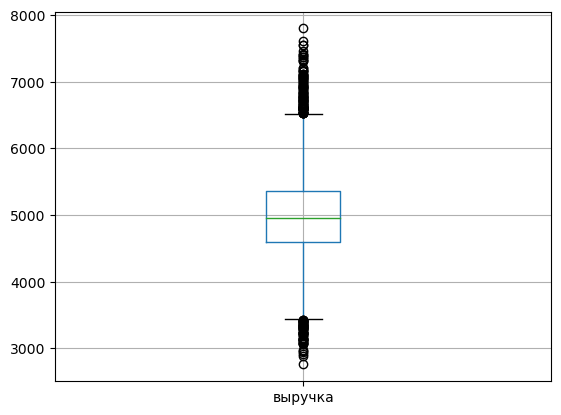

In [65]:
market_money.boxplot('выручка');

Теперь наши данные выглядят нормально, распределение от 2750 до 7800 руб., наибольшее количество покупателей тратят около 5000 руб. в мес. Думаю пока стоит оставить данные в таком виде.

**3. Данные о времен и проведенном на сайте**

In [66]:
market_time.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


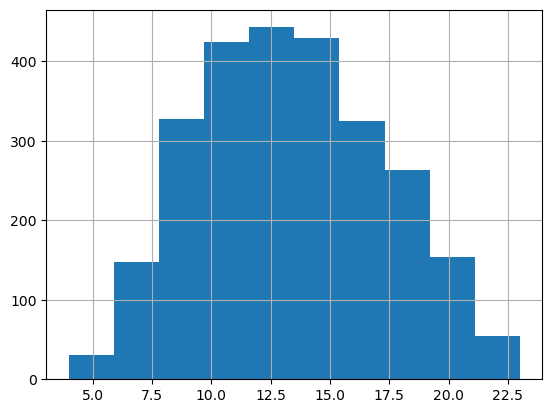

In [67]:
market_time['минут'].hist();

Наибольшее количество покупателей находится на сайте от 10 до 15 минут. Оставим данные в таком виде.

**4. Данные о полученной прибыли**

In [68]:
money.describe()

,id,прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


In [69]:
money.head()

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


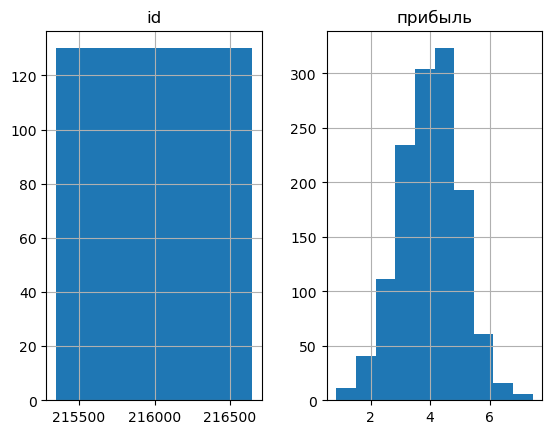

In [70]:
money.hist();

In [71]:
market_file.head()

,id,покупательская_активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


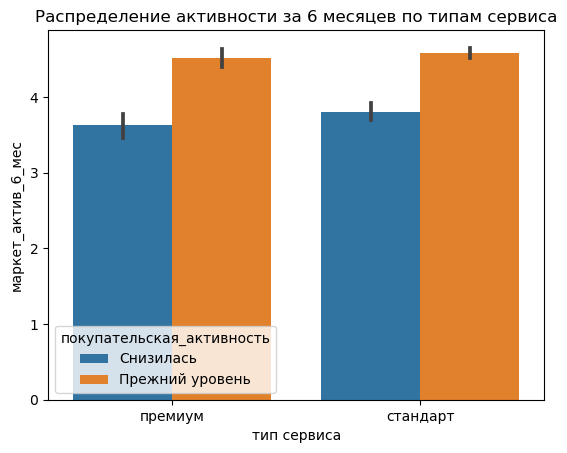

In [72]:
ax = sns.barplot(x = 'тип сервиса',
            y = 'маркет_актив_6_мес',
            hue = "покупательская_активность",
            data = market_file)

plt.title("Распределение активности за 6 месяцев по типам сервиса")
plt.xlabel('тип сервиса')
plt.ylabel('маркет_актив_6_мес')
plt.show()

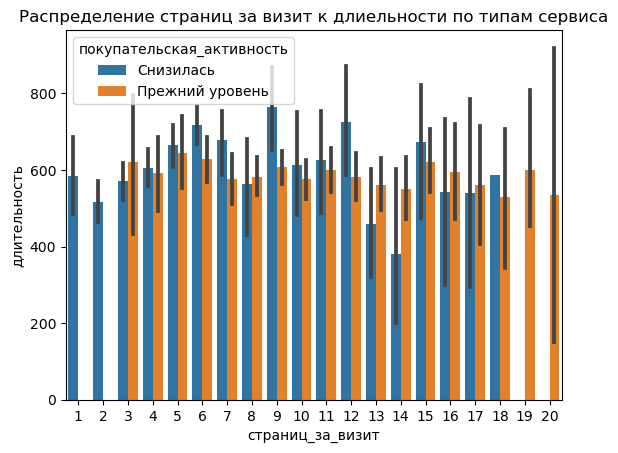

In [73]:
ax = sns.barplot(x = 'страниц_за_визит',
            y = 'длительность',
            hue = "покупательская_активность",
            data = market_file)

plt.title("Распределение страниц за визит к длиельности по типам сервиса")
plt.xlabel('страниц_за_визит')
plt.ylabel('длительность')
plt.show()

Действительно, заметно, что сниженная покупательская активность заметна у покупателей не посещающих более 5 страниц. Возможно это связано с ошибками сервиса. Построим график.

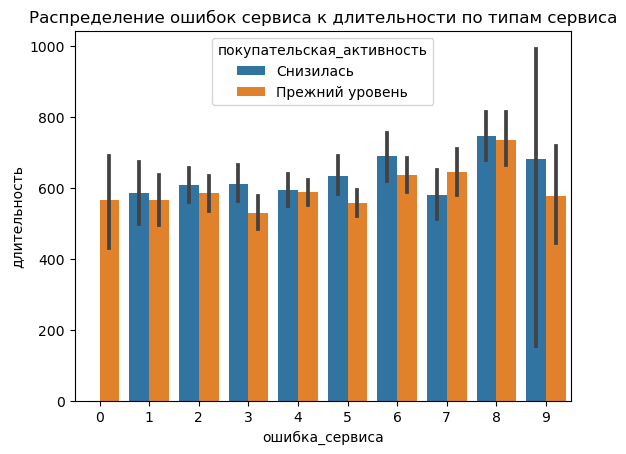

In [74]:
ax = sns.barplot(x = 'ошибка_сервиса',
            y = 'длительность',
            hue = "покупательская_активность",
            data = market_file)

plt.title("Распределение ошибок сервиса к длительности по типам сервиса")
plt.xlabel('ошибка_сервиса')
plt.ylabel('длительность')
plt.show()

Наибольшее снижение активности у пользователей с 8 и 9 ошибками. Нужно срочно все исправлять.

Разобьем датасет на 2  новых, это для пользователей сниженной покупательской активностью и прежним уровнем.

In [75]:
lower = market_file.query("покупательская_активность == 'Снизилась'")
previous_level = market_file.query("покупательская_активность == 'Прежний уровень'")

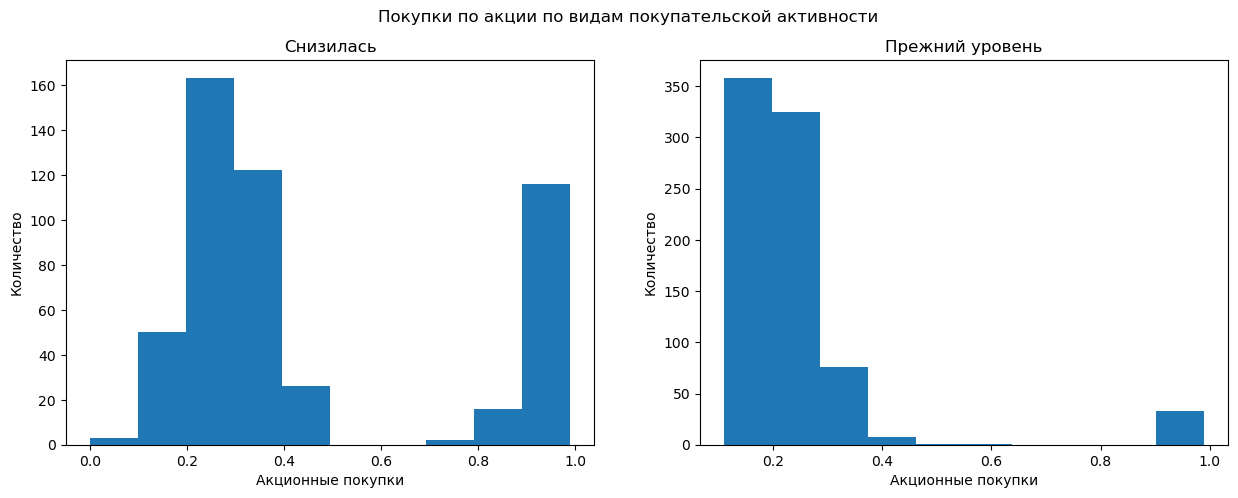

In [76]:
plt.subplots(figsize=(15, 5))
plt.suptitle('Покупки по акции по видам покупательской активности')

plt.subplot(1, 2, 1)
plt.hist(lower['акционные_покупки'])
plt.title('Снизилась')
plt.xlabel('Акционные покупки')
plt.ylabel('Количество')
 
plt.subplot(1, 2, 2)
plt.hist(previous_level['акционные_покупки'])
plt.title('Прежний уровень')
plt.xlabel('Акционные покупки')
plt.ylabel('Количество')

plt.show()

Как видно из графика, у покупателей, которых снизилась покупательская активность довольно большую часть занимают акционные покупки. Те же покупатели которые остались на прежнем уровне, почти не приобретают товары по акции. Думаю нужно покупателям со ниженной активностью предложить больше товара по акции. Это стимулирует рост продаж, да и люди будут чаще заходить на сай и проверять товар по акции.

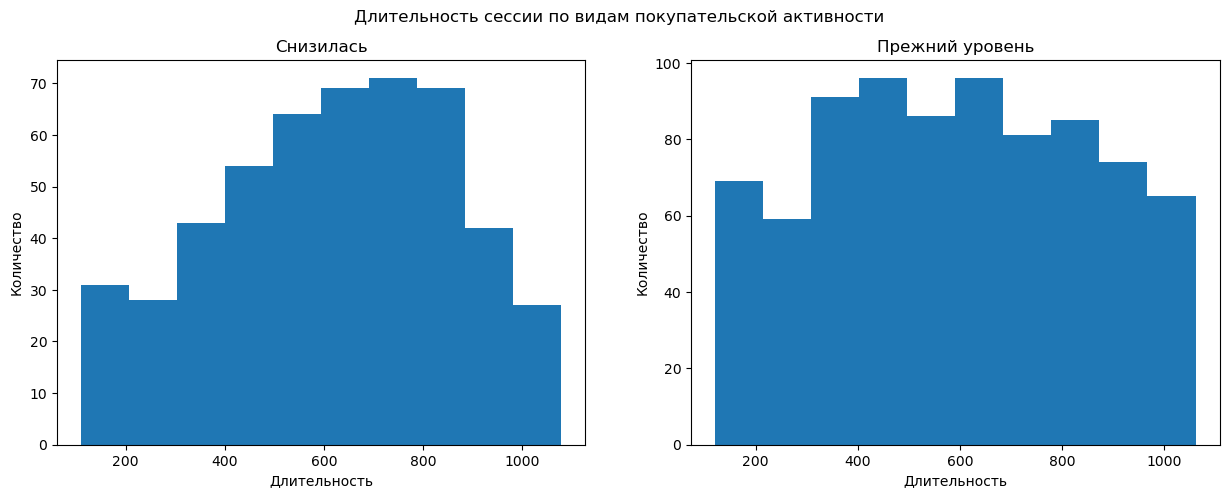

In [77]:
plt.subplots(figsize=(15, 5))
plt.suptitle('Длительность сессии по видам покупательской активности')

plt.subplot(1, 2, 1)
plt.hist(lower['длительность'])
plt.title('Снизилась')
plt.xlabel('Длительность')
plt.ylabel('Количество')
 
plt.subplot(1, 2, 2)
plt.hist(previous_level['длительность'])
plt.title('Прежний уровень')
plt.xlabel('Длительность')
plt.ylabel('Количество')

plt.show()

У пользователей со сниженной активностью наблюдается пик в районе 700 дней, возможно за это время им перестало быть нужны определенные категории товаров. Ну в частности товаров для детей, дети ведь растут, да и товары для дома часто покупать не нужно. В то же время, у пользователей с прежним уровнем пик растянут от года до 2-х лет.

In [78]:
lower_count = lower.pivot_table(index='популярная_категория',values='id',aggfunc='count')
previous_level_count = previous_level.pivot_table(index='популярная_категория',values='id',aggfunc='count')

In [79]:
lower_count

,id
популярная_категория,
Домашний текстиль,102
Косметика и аксесуары,105
Кухонная посуда,66
Мелкая бытовая техника и электроника,27
Техника для красоты и здоровья,52
Товары для детей,146


In [80]:
labels = [
    'Домашний текстиль', 'Косметика и аксесуары', 
    'Кухонная посуда', 'Мелкая бытовая техника и электроника', 
    'Техника для красоты и здоровья', 'Товары для детей']

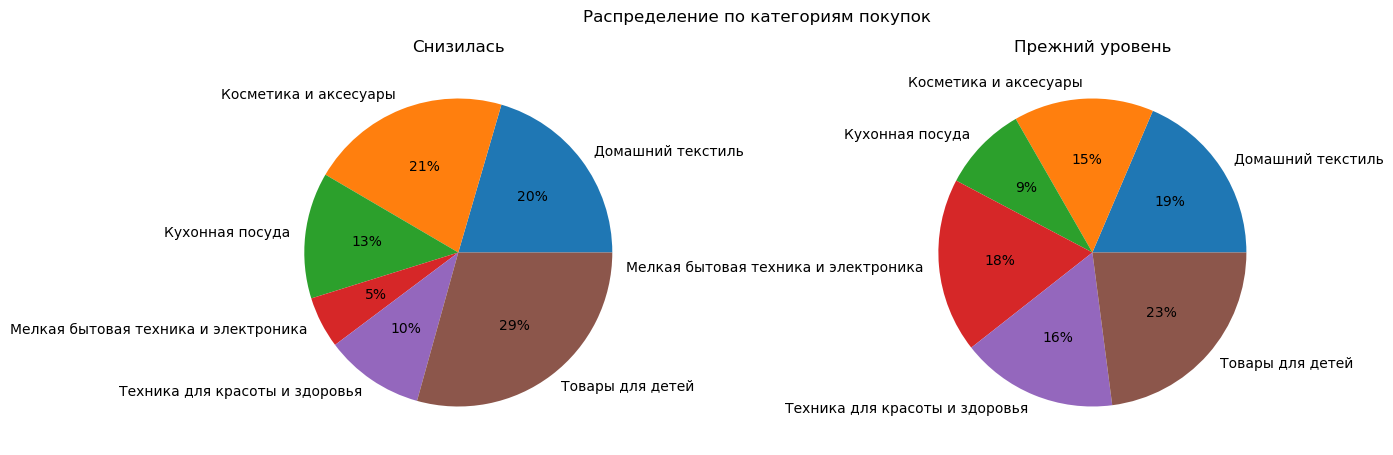

In [81]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plt.suptitle('Распределение по категориям покупок')
#plt.title('Снизилась')
df1 = ax1.pie(x=lower_count['id'],labels=labels, autopct='%1.0f%%')
df2 = ax2.pie(x=previous_level_count['id'], labels=labels, autopct='%1.0f%%')
ax1.set_title('Снизилась')
ax2.set_title('Прежний уровень');

Как мы видим распределение сильно отличается, от тех у кого остался прежний уровень и у кого снизилась покупательская активность. Те у кого снизилась, преобладают товары для детей и косметтика и аксессуары. В то же время, как у покупателей с прежним уровнем немалую долю занимают категории мелкая бытоая техника и техника для красоты и здоровья.

In [82]:
lower_subscription = lower.pivot_table(index='тип сервиса',values='id',aggfunc='count')
previous_level_subscription = previous_level.pivot_table(index='тип сервиса',values='id',aggfunc='count')

In [83]:
labels2 = ['премиум', 'стандарт']

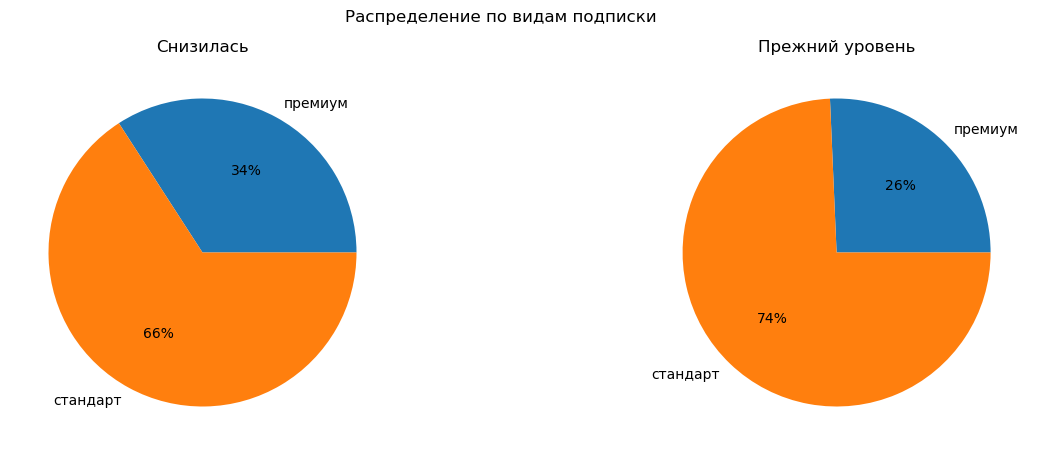

In [84]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plt.suptitle('Распределение по видам подписки')
#plt.title('Снизилась')
df1 = ax1.pie(x=lower_subscription['id'],labels=labels2, autopct='%1.0f%%')
df2 = ax2.pie(x=previous_level_subscription['id'], labels=labels2, autopct='%1.0f%%')
ax1.set_title('Снизилась')
ax2.set_title('Прежний уровень');

Интересно получается, премиум у клиентов со снижением занимает 34 %, в то же время как у клиентов с прежним уровнем всего 26 %. Думаю предлагать бесплатную подписку, для клиентов со снижением активности не принесет особого результата.

**Отберем клиентов с покупательской активностью не менее трёх месяцев**

In [85]:
market_money_summary = pd.pivot_table(market_money, index='id', columns='период', values='выручка')
market_money_summary

период,предпредыдущий_месяц,предыдущий_месяц,текущий_месяц
id,,,
215348,NaN,NaN,3293.100098
215349,4472.0,5216.0,4971.600098
215350,4826.0,5457.5,5058.399902
215351,4793.0,6158.0,6610.399902
215352,4594.0,5807.5,5872.500000
...,...,...,...
216643,4704.0,3664.0,4741.700195
216644,5299.0,4729.0,5353.000000
216645,5334.0,5160.0,5139.200195


Не все покупатели покупали, что то в магазине в течении 3-х месяцев подряд. Всех клиентов которые хоть один месяц ничего не покупали нужно удалить.

In [86]:
market_money_summary = market_money_summary.dropna()
market_money_summary

период,предпредыдущий_месяц,предыдущий_месяц,текущий_месяц
id,,,
215349,4472.0,5216.0,4971.600098
215350,4826.0,5457.5,5058.399902
215351,4793.0,6158.0,6610.399902
215352,4594.0,5807.5,5872.500000
215353,5124.0,4738.5,5388.500000
...,...,...,...
216643,4704.0,3664.0,4741.700195
216644,5299.0,4729.0,5353.000000
216645,5334.0,5160.0,5139.200195


Удалили 4 клиентов не соответствующих условиям выборки.

**Вывод.**
1. По иследованию таблицы с данными клиентов можно сделать следующие выводы:
    - У 38 % пользователей снизилась покупательская активность. Довольно большой %, стоит задуматься над привлечением клиентов.
    - Большинство, а именно 71 % пользуются сервисом "Стандарт". Покупатели не стремятся приобрести подписку премиум.
    - 3/4 от покупателей разрешили уведомлять их, это говорит о том, что им все же интересны акции платформы.
    - 25 % занимает категория "Товары для детей", "Домашний текстиль" 19 %, "Косметика и аксессуары" 17 %. Да и остальные категории отностятся к категории быта. Могу предположить, что основной контингент пользователей это молодые женщины с детьми. Стоит подумать над расширением ассортимента для данной категории людей.
2. По данными с выручкой могу сказать, что был клиент купивший товаров на сайте более чем на 106 тыс. руб. Но при обучении даннык лиет будет создавать сильный сдвиг, поэтому этого клиента мы не будем использовать в анализе. Также были клиенты с 0 суммой. Вероятно это ошибка заполнения данных, либо отказ от покупки. Таких клиентов мы тоже не будем использовать.
3. Наибольшее количество покупателей находится на сайте от 10 до 15 минут. 
4. С данными о прибыли не понятно в какой форме выражены данные. Я предполагаю что это % от выручки.
5. Согласно тех заданию нужно использовать данные с клиентами, которы в течении 3-х месяцев делали покупки. Клиентов с пропусками я удалил.
6. Наибольшее снижение активности у пользователей с 8 и 9 ошибками сервиса.
7. сниженная покупательская активность заметна у покупателей не посещающих более 5 страниц. 
8. Распределение по категориям товаров сильно отличается, от тех у кого остался прежний уровень и у кого снизилась покупательская активность. Те у кого снизилась, преобладают товары для детей и косметтика и аксессуары. В то же время, как у покупателей с прежним уровнем немалую долю занимают категории мелкая бытоая техника и техника для красоты и здоровья.
9. Премиум у клиентов со снижением занимает 34 %, в то же время как у клиентов с прежним уровнем всего 26 %. Думаю предлагать бесплатную подписку, для клиентов со снижением активности не принесет особого результата.

## Шаг 4. Объединение таблиц

Так как по тех заданию нужно использовать только тех клиентов у которых были покупки за последние 3 месяца, то мы будем объединять к данным с продажами остальные данные.

Первое что мы сделаем, это присоеденим к данным о продажах, данные о покупателях.

In [87]:
data = market_money_summary.merge(market_file, on ='id', how='inner')

Так как данные о времени распределены в столбец, то перенесем данные в строку. 

In [88]:
market_time_summary = pd.pivot_table(market_time, index='id', columns='период', values='минут')
market_time_summary.head()

период,предыдущий_месяц,текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


Переименуем столбцы, т.к с такими названия столбцы уже есть.

In [89]:
market_time_summary = market_time_summary.rename (columns= {'предыдущий_месяц': 'предыдущий_время', 'текущий_месяц': 'текущий_время'})

Посмотрим что получилось

In [90]:
market_time_summary.head()

период,предыдущий_время,текущий_время
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


In [91]:
market_time_summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   предыдущий_время  1300 non-null   int64
 1   текущий_время     1300 non-null   int64
dtypes: int64(2)
memory usage: 30.5 KB


1300 строк именно столько у нас покупателей.

Теперь к данным общим притянем данные о времени на сайте.

In [92]:
data = data.merge(market_time_summary, on ='id', how='inner')

Проверим, что получилось.

In [93]:
data.head()

,id,предпредыдущий_месяц,предыдущий_месяц,текущий_месяц,покупательская_активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_время,текущий_время
0,215349,4472.0,5216.0,4971.600098,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10
1,215350,4826.0,5457.5,5058.399902,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13
2,215351,4793.0,6158.0,6610.399902,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13
3,215352,4594.0,5807.5,5872.500000,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11
4,215353,5124.0,4738.5,5388.500000,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10


In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   предпредыдущий_месяц                 1296 non-null   float32
 2   предыдущий_месяц                     1296 non-null   float32
 3   текущий_месяц                        1296 non-null   float32
 4   покупательская_активность            1296 non-null   object 
 5   тип сервиса                          1296 non-null   object 
 6   разрешить сообщать                   1296 non-null   object 
 7   маркет_актив_6_мес                   1296 non-null   float32
 8   маркет_актив_тек_мес                 1296 non-null   int64  
 9   длительность                         1296 non-null   int64  
 10  акционные_покупки                    1296 non-null   float32
 11  популярная_категория          

Ничего не потерялось. Думаю надо расставить столбцы так, чтобы легче было читать данные.

In [95]:
data.columns

Index(['id', 'предпредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц',
       'покупательская_активность', 'тип сервиса', 'разрешить сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'предыдущий_время', 'текущий_время'],
      dtype='object')

In [96]:
data = data[['id', 'тип сервиса', 'популярная_категория', 
             'покупательская_активность', 'разрешить сообщать',
             'предпредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц',
             'маркет_актив_6_мес', 'маркет_актив_тек_мес',
             'акционные_покупки', 'страниц_за_визит', 
             'средний_просмотр_категорий_за_визит',
             'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
             'предыдущий_время', 'текущий_время', 'длительность']]

In [97]:
data.sample(3)

,id,тип сервиса,популярная_категория,покупательская_активность,разрешить сообщать,предпредыдущий_месяц,предыдущий_месяц,текущий_месяц,маркет_актив_6_мес,маркет_актив_тек_мес,акционные_покупки,страниц_за_визит,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,предыдущий_время,текущий_время,длительность
341,215693,стандарт,Домашний текстиль,Снизилась,да,4483.0,4502.0,4615.100098,5.6,5,0.28,9,3,2,3,16,6,574
913,216265,стандарт,Домашний текстиль,Прежний уровень,да,4750.0,5881.0,6991.200195,4.2,3,0.30,9,3,4,4,15,13,846
888,216240,стандарт,Мелкая бытовая техника и электроника,Прежний уровень,да,5637.0,5226.0,4999.799805,5.2,4,0.11,10,3,2,0,22,15,202


В текущем пункте мы объединили таблицы с продажами с данными о покупателях и временем проведенном на сайте. Предварительно данные о продажах и данные о времени на сайте развернули в соответсвии с запросом техзадания.

## Шаг 5. Корреляционный анализ

Создадим диаграммы рассеивания.

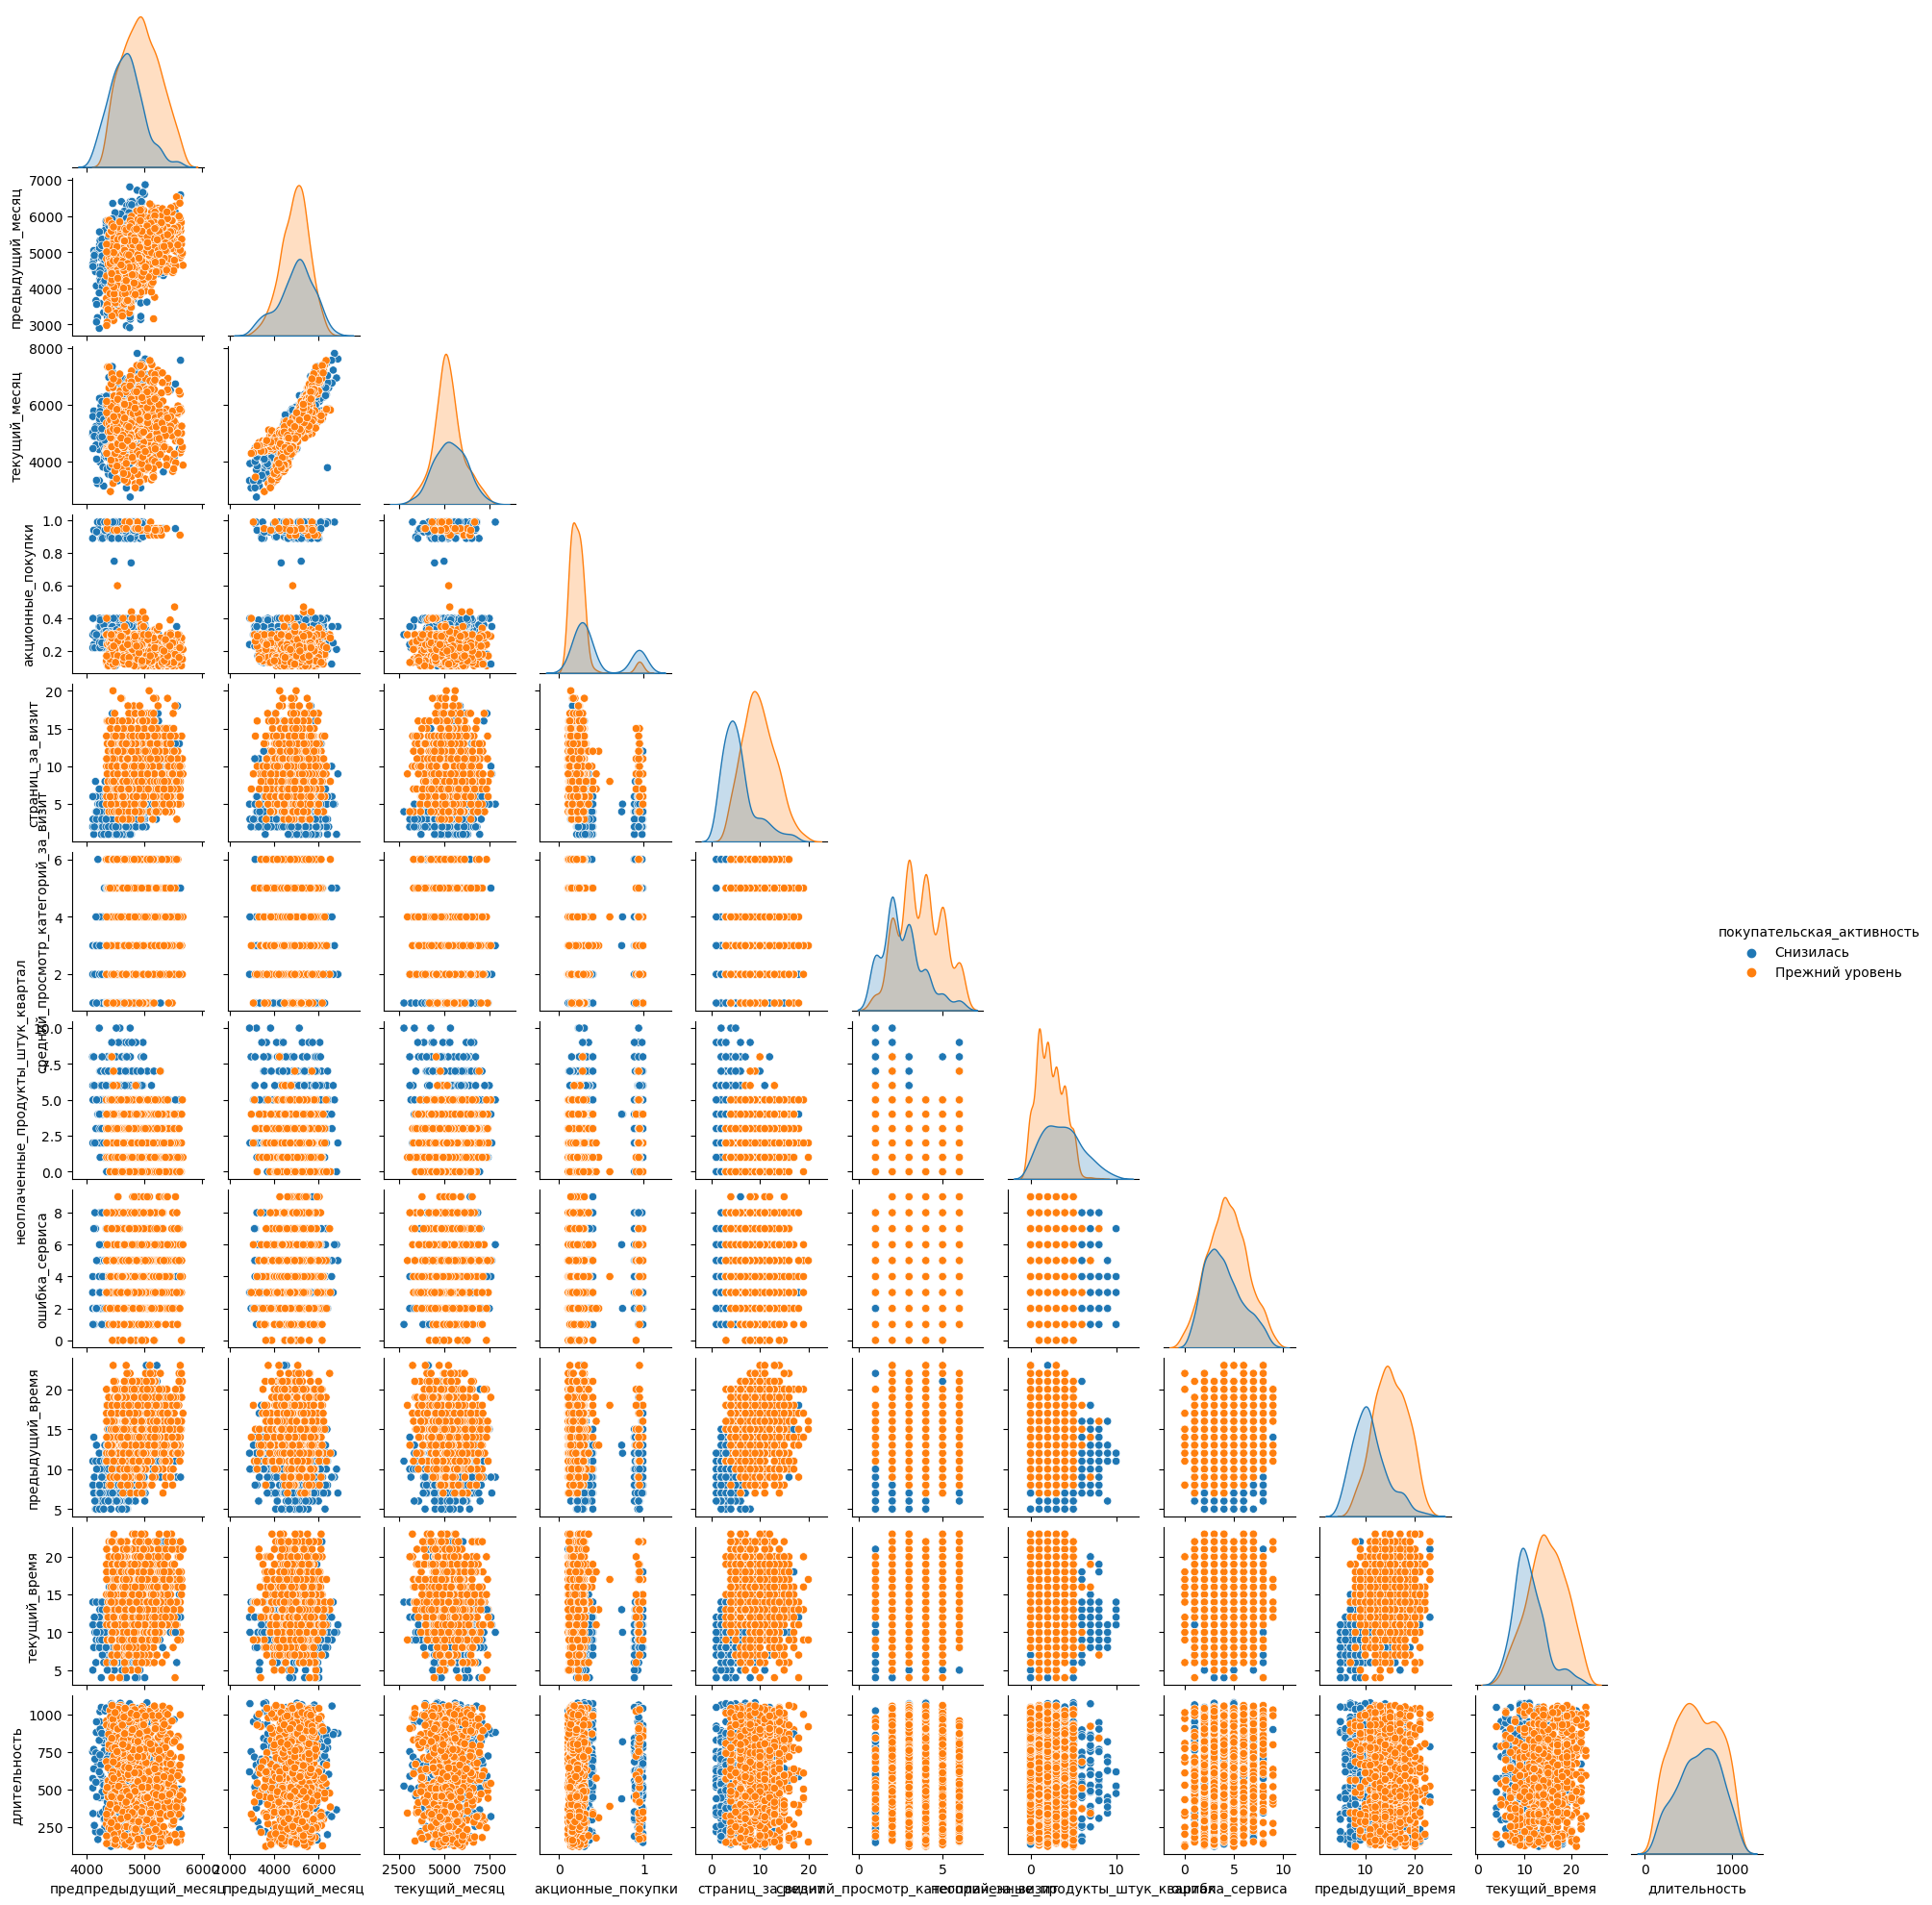

In [98]:
cols_numeric = ['тип сервиса', 'популярная_категория', 
             'покупательская_активность', 'разрешить сообщать',
             'предпредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц',
             'акционные_покупки', 'страниц_за_визит', 
             'средний_просмотр_категорий_за_визит',
             'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
             'предыдущий_время', 'текущий_время', 'длительность']
df = data[cols_numeric]
g = sns.pairplot(df, corner=True, hue="покупательская_активность")
g.fig.set_size_inches(20, 20)

Мы видим разделение доли покупок по акциям на 2 категории до 0.6 и больше. Данный признак думаю отнести к категориальному, т.к. некоторые покупатели приобретают товары только по акции.

In [99]:
data['акция'] = data['акционные_покупки'].apply(lambda x: True if x >= 0.6 else False)

Теперь нам нужно выяснить, где и в каких показателях линейная зависимость показателей.

In [100]:
data_phik = data.phik_matrix()
data_phik

interval columns not set, guessing: ['id', 'предпредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'акционные_покупки', 'страниц_за_визит', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'предыдущий_время', 'текущий_время', 'длительность']


,id,тип сервиса,популярная_категория,покупательская_активность,разрешить сообщать,предпредыдущий_месяц,предыдущий_месяц,текущий_месяц,маркет_актив_6_мес,маркет_актив_тек_мес,акционные_покупки,страниц_за_визит,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,предыдущий_время,текущий_время,длительность,акция
id,1.000000,0.111740,0.170782,0.984480,0.020168,0.419805,0.236255,0.162042,0.467226,0.000000,0.410600,0.608890,0.354298,0.420243,0.202559,0.564809,0.472934,0.024895,0.430838
тип сервиса,0.111740,1.000000,0.070809,0.129940,0.289965,0.066183,0.000000,0.124220,0.089911,0.045258,0.030010,0.102594,0.185391,0.139721,0.079515,0.131814,0.000000,0.404851,0.000000
популярная_категория,0.170782,0.070809,1.000000,0.299717,0.073684,0.044978,0.250694,0.238893,0.150386,0.136243,0.122385,0.160300,0.226116,0.251593,0.000000,0.195233,0.089883,0.000000,0.050035
покупательская_активность,0.984480,0.129940,0.299717,1.000000,0.000000,0.495596,0.220951,0.195050,0.544831,0.000000,0.506276,0.749888,0.539607,0.505680,0.224154,0.685138,0.576770,0.098109,0.489158
разрешить сообщать,0.020168,0.289965,0.073684,0.000000,1.000000,0.000000,0.070283,0.077990,0.000000,0.052618,0.012198,0.042134,0.070359,0.205062,0.021839,0.038387,0.000000,0.253624,0.000000
предпредыдущий_месяц,0.419805,0.066183,0.044978,0.495596,0.000000,1.000000,0.351659,0.410328,0.316412,0.006916,0.225374,0.334587,0.176100,0.257685,0.139787,0.421314,0.341406,0.100162,0.180874
предыдущий_месяц,0.236255,0.000000,0.250694,0.220951,0.070283,0.351659,1.000000,0.833425,0.159486,0.059030,0.064748,0.148681,0.096615,0.192253,0.000000,0.121678,0.196216,0.129962,0.015837
текущий_месяц,0.162042,0.124220,0.238893,0.195050,0.077990,0.410328,0.833425,1.000000,0.000000,0.000000,0.065171,0.133190,0.087442,0.174096,0.000000,0.234493,0.258497,0.142710,0.060043
маркет_актив_6_мес,0.467226,0.089911,0.150386,0.544831,0.000000,0.316412,0.159486,0.000000,1.000000,0.079854,0.279553,0.396769,0.206788,0.277692,0.142401,0.363950,0.330601,0.000000,0.245295
маркет_актив_тек_мес,0.000000,0.045258,0.136243,0.000000,0.052618,0.006916,0.059030,0.000000,0.079854,1.000000,0.000000,0.000000,0.246633,0.140967,0.116946,0.107945,0.061410,0.176948,0.000000


Здесь мы наблюдаем сильную корреляционную связь между покупательской активностью и количеством страниц за визит. 

In [101]:
#data['страниц_за_визит'] = data['страниц_за_визит'] ** 2

In [102]:
data.tail(10)

,id,тип сервиса,популярная_категория,покупательская_активность,разрешить сообщать,предпредыдущий_месяц,предыдущий_месяц,текущий_месяц,маркет_актив_6_мес,маркет_актив_тек_мес,акционные_покупки,страниц_за_визит,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,предыдущий_время,текущий_время,длительность,акция
1286,216638,стандарт,Мелкая бытовая техника и электроника,Прежний уровень,нет,4613.0,3234.0,4557.399902,1.5,3,0.29,16,2,0,4,11,14,930,False
1287,216639,стандарт,Товары для детей,Прежний уровень,да,4591.0,4648.0,4827.399902,4.8,4,0.29,7,4,5,3,14,22,306,False
1288,216640,стандарт,Кухонная посуда,Прежний уровень,нет,4679.0,4212.5,3938.199951,5.7,4,0.95,13,2,3,5,23,17,416,True
1289,216641,стандарт,Техника для красоты и здоровья,Прежний уровень,да,5176.0,5654.5,6199.200195,4.1,4,0.22,14,4,1,6,14,12,638,False
1290,216642,премиум,Мелкая бытовая техника и электроника,Прежний уровень,да,5011.0,4589.5,4354.200195,4.2,3,0.40,12,4,3,5,19,19,991,False
1291,216643,стандарт,Техника для красоты и здоровья,Прежний уровень,да,4704.0,3664.0,4741.700195,6.6,3,0.24,11,5,3,3,14,7,318,False
1292,216644,стандарт,Домашний текстиль,Прежний уровень,нет,5299.0,4729.0,5353.000000,5.1,4,0.21,9,6,2,3,12,11,454,False
1293,216645,стандарт,Домашний текстиль,Прежний уровень,да,5334.0,5160.0,5139.200195,4.1,3,0.20,7,3,2,5,12,18,586,False
1294,216646,стандарт,Техника для красоты и здоровья,Прежний уровень,да,4725.0,4923.0,5224.600098,6.3,5,0.12,7,3,3,5,18,7,645,False
1295,216647,премиум,Техника для красоты и здоровья,Прежний уровень,да,5183.0,4720.0,4448.299805,4.0,5,0.94,12,4,5,3,15,10,906,True


В корреляционном анализе мы  разделили на 2 группы покупки по акции.

## Шаг 6. Использование пайплайнов

**Самый долгий шаг в проекте. Делался около 3-х суток на платформе Яндекса. После был пределан в Анаконде на компьютере и расчет произвелся за время меньше минуты. Прошу учесть эту проблему при проверке.**

Сделаем список столбцов.

In [103]:
data.columns

Index(['id', 'тип сервиса', 'популярная_категория',
       'покупательская_активность', 'разрешить сообщать',
       'предпредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'акционные_покупки',
       'страниц_за_визит', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'предыдущий_время', 'текущий_время', 'длительность', 'акция'],
      dtype='object')

Сделаем копию нашего датафрема для проведения моделирования.

In [104]:
df = data.copy()

Удалим столбец ID.

In [105]:
df = df.set_index('id')

Запустим отключения отображения предупреждения.

Создадим подбор гиперпараметров по моделям KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Выясним какая модель наиболее подходит для наших данных. Будем использовать стратегию "использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт вам лучшую модель".

In [106]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
# загружаем данные
X = df.drop(['покупательская_активность'], axis=1)
y = df['покупательская_активность']


X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE, stratify=y
)

# создаём списки
ohe_columns = ['популярная_категория', 
               'маркет_актив_тек_мес', 
               'средний_просмотр_категорий_за_визит', 
               'неоплаченные_продукты_штук_квартал', 
               'ошибка_сервиса',
               'страниц_за_визит']

ord_columns = ['тип сервиса', 'разрешить сообщать', 'акция']

num_columns = ['маркет_актив_6_мес', 
               'длительность',  
               'текущий_месяц', 
               'текущий_время',
               'предпредыдущий_месяц',
               'предыдущий_месяц',
               'акционные_покупки',
               'предыдущий_время']

ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
        )
    ]
)

# cоздаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['премиум', 'стандарт'],
                    ['да', 'нет'],
                    [True, False]
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid = [
    {'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
     'models__max_depth': range(2,5),
     'models__max_features': range(2,5),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
 
    {'models': [KNeighborsClassifier()],
     'models__n_neighbors': range(2,5),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
 
    {'models': [LogisticRegression(
        random_state=RANDOM_STATE, 
        solver='liblinear', 
        penalty='l1')],
     'models__C': range(1,5),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
    
    {'models': [SVC(random_state=RANDOM_STATE, probability=True)],
     'models__C':[0.1,1,10,100,1000],
     'models__kernel':['rbf', 'poly', 'sigmoid', 'linear'],
     'models__degree':[1,2,3,4,5,6],
     'models__gamma':[1,0.1,0.01,0.001,0.0001],
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}

]
 
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1)
randomized_search.fit(X_train, y_train)
y_test_pred = randomized_search.predict(X_test)
result = X_test.copy()
result['вероятность снижения'] = randomized_search.predict_proba(X_test)[:,1]
 
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', accuracy_score(y_test, y_test_pred))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['популярная_категория',
                                                   'маркет_актив_тек_мес',
                                                   'средний_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_штук_квартал',
                        

    Наилучшая модель для наших данных SVC(C=10, degree=6, gamma=0.0001, kernel='linear', probability=True, random_state=42), 'num', MinMaxScaler(). При написании последующих моделей будем использовать эти гиперпараметры.
    accuracy_score = 0.9

## Шаг 7. Анализ важности признаков

Оценка значимости признаков при классификации отдельных наблюдений позволяют детальнее всего интерпретировать модель и даже понять, почему она ошиблась в каждом конкретном случае. Сформируем данные для постройки графиков.

In [107]:
# делаем обработку данных train
x_Train = pipe_final.named_steps['preprocessor'].fit_transform(X_train)

# задаем объект shap.Explainer()
explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['models'], x_Train)
x_Test = pipe_final.named_steps['preprocessor'].transform(X_test)
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
# делаем обработку данных test
x_Test = pd.DataFrame(x_Test, columns=feature_names)

# объясняем переменные
shap_values = explainer(x_Test)

Посмотрим, как признаки влияют на каждое предсказание модели:

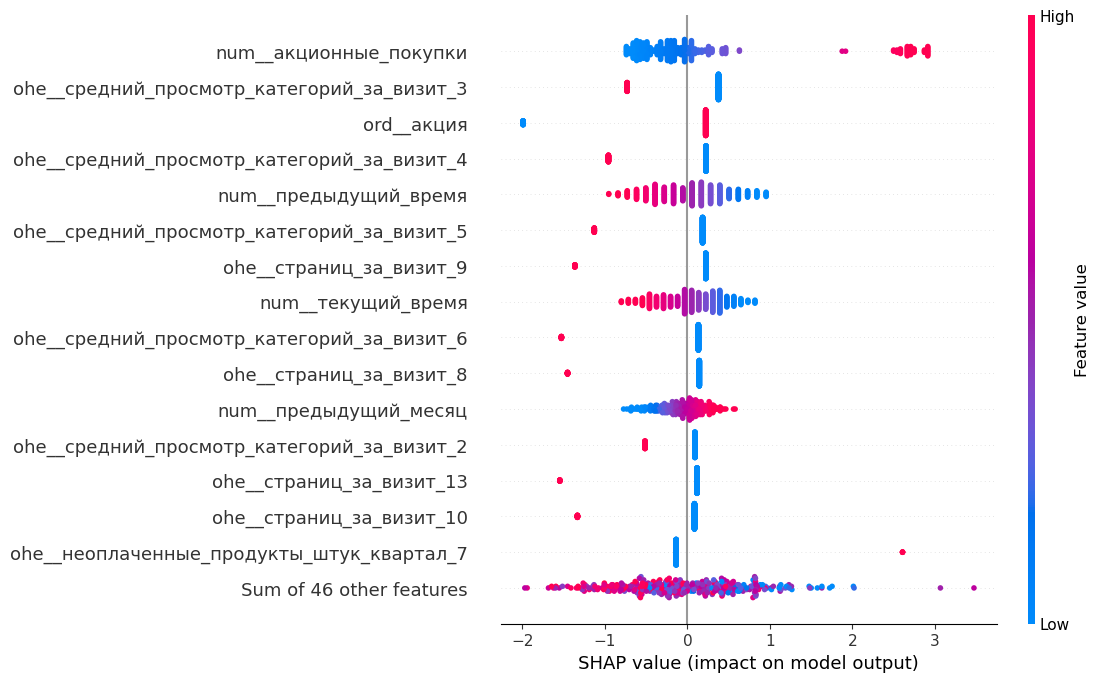

In [108]:
shap.plots.beeswarm(shap_values, max_display=16)

Построим график общей значимости признаков:

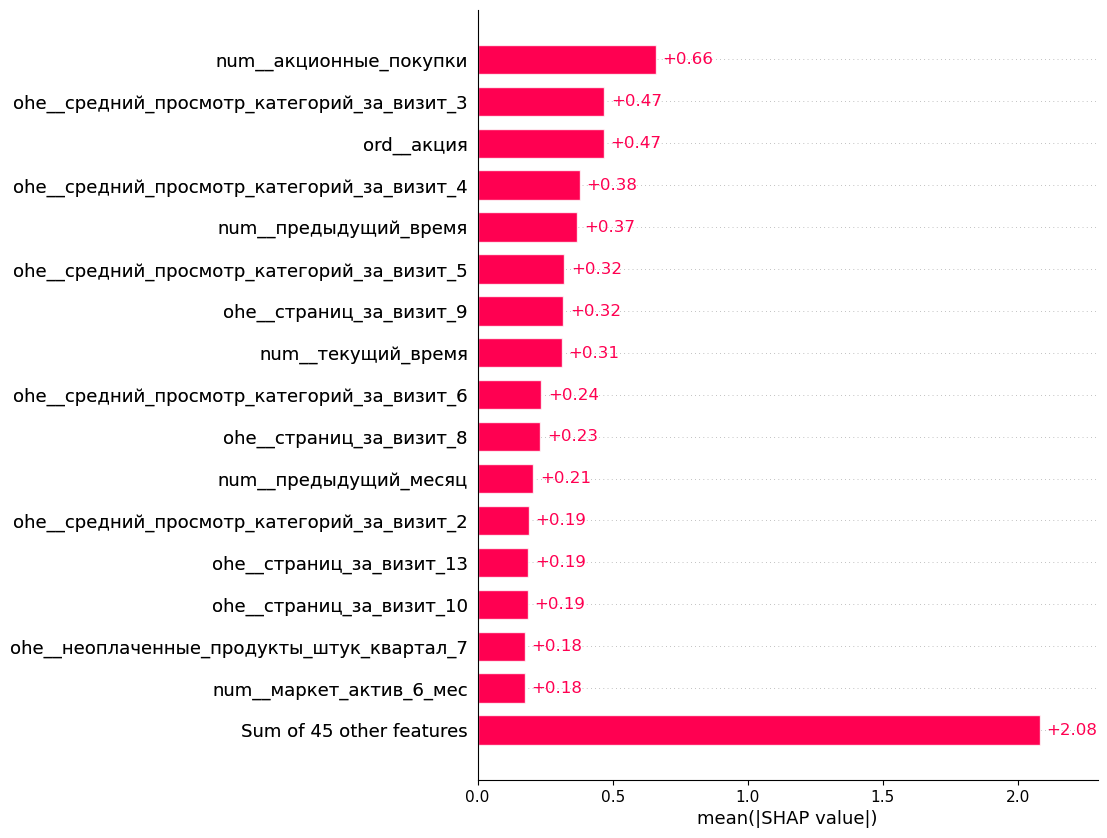

In [109]:
shap.plots.bar(shap_values, max_display=17) 

Оценим вклад каждого признака:

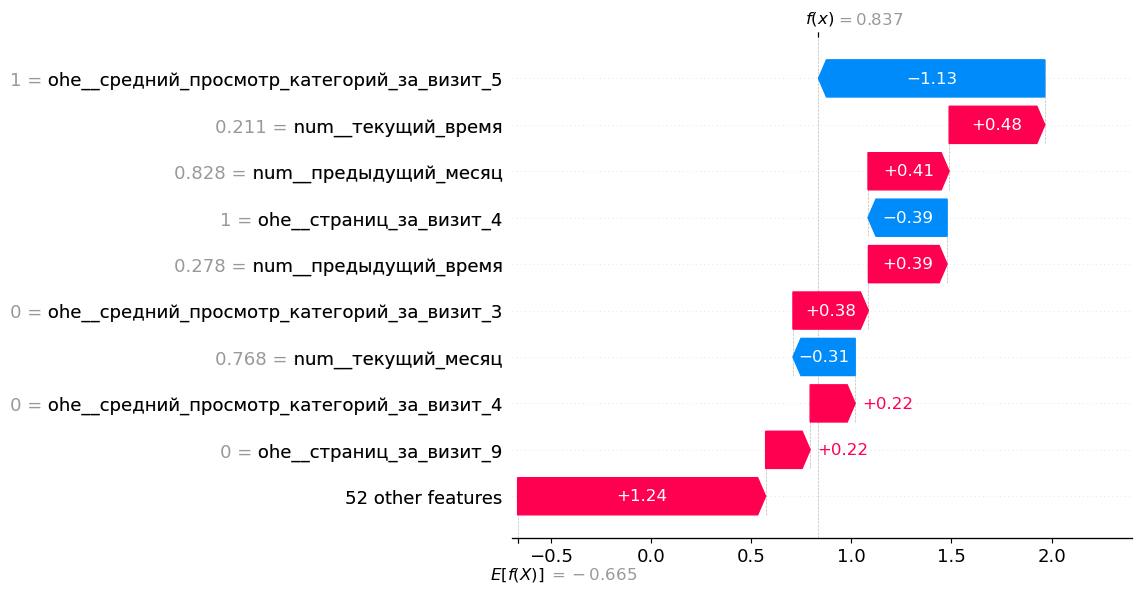

In [110]:
shap.plots.waterfall(shap_values[181])

Permutation importance подсвечивает качество модели с ещё одной стороны. Он показывает, насколько изменятся метрики, если поочерёдно рандомизировать каждый входной признак модели. 

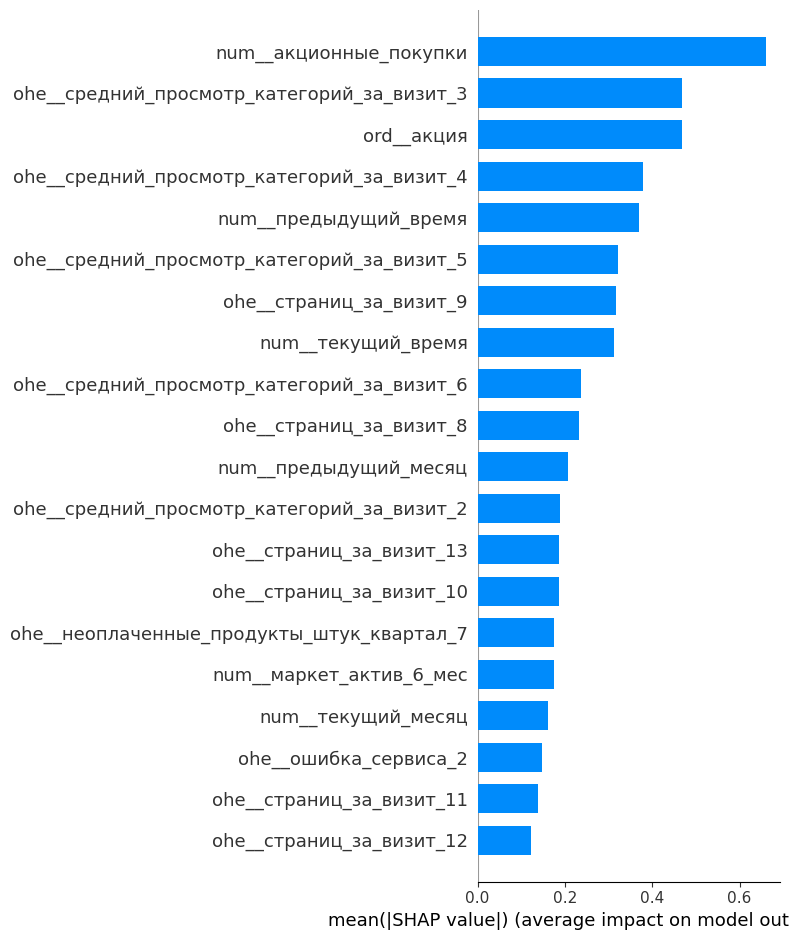

In [111]:
shap.summary_plot(shap_values, x_Test, plot_type="bar", 
                  feature_names=pipe_final.named_steps['preprocessor'].get_feature_names_out())

Наибольшее влияние на целевой признак "Покупательская активность" оказывают акционные покупки, вероятно клиенты ищут товары по акции и стараются купить товар как можно выгоднее. Также влияют столбцы: предъыдущий_время, средний просмотр категорий за визит, и текущий время. Думаю это можно объяснить поведением покупателя. Просто так на сайт заходить не будут, и если кто-то, что-то даже не хотел покупать, но увидит хорошую цену, то обязательно приобретет товар.

## Шаг 8. Сегментация покупателей

При составлении паплайна, сразу был создан новый датафрейм куда были добавлены данные о вероятности снижения покупательской активности.

In [112]:
result.head()

,тип сервиса,популярная_категория,разрешить сообщать,предпредыдущий_месяц,предыдущий_месяц,текущий_месяц,маркет_актив_6_мес,маркет_актив_тек_мес,акционные_покупки,страниц_за_визит,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,предыдущий_время,текущий_время,длительность,акция,вероятность снижения
id,,,,,,,,,,,,,,,,,,
216161,стандарт,Техника для красоты и здоровья,да,4912.0,3973.0,3289.199951,4.1,4,0.15,12,6,1,4,16,17,606,False,0.029930
215654,премиум,Товары для детей,нет,4656.0,3548.0,4170.700195,1.4,4,0.94,6,3,6,1,11,9,684,True,0.766725
216307,премиум,Домашний текстиль,да,4565.0,5444.0,6335.799805,3.3,4,0.13,10,4,2,8,20,11,488,False,0.060479
215501,премиум,Домашний текстиль,да,4993.0,6604.0,6758.700195,3.5,3,0.35,6,4,3,5,9,9,1057,False,0.810852
215934,стандарт,Мелкая бытовая техника и электроника,нет,4451.0,5090.0,5773.799805,5.5,4,0.99,7,1,2,3,15,18,147,True,0.586864


Вернем столбец ID.

In [113]:
result = result.reset_index('id')
result.tail()

,id,тип сервиса,популярная_категория,разрешить сообщать,предпредыдущий_месяц,предыдущий_месяц,текущий_месяц,маркет_актив_6_мес,маркет_актив_тек_мес,акционные_покупки,страниц_за_визит,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,предыдущий_время,текущий_время,длительность,акция,вероятность снижения
319,215429,премиум,Домашний текстиль,нет,4488.0,3662.0,4158.600098,0.9,4,0.24,4,2,5,7,11,10,690,False,0.901039
320,216233,премиум,Техника для красоты и здоровья,да,4553.0,4325.0,4257.399902,3.9,4,0.21,14,3,0,6,15,17,1048,False,0.061638
321,215716,стандарт,Техника для красоты и здоровья,да,4165.0,3067.0,3343.899902,2.4,4,0.30,3,3,5,2,13,14,952,False,0.754129
322,216141,стандарт,Косметика и аксесуары,нет,4885.0,5660.5,6462.600098,4.0,4,0.28,9,4,0,4,14,10,748,False,0.167685
323,215670,стандарт,Кухонная посуда,да,4563.0,5415.0,5723.100098,4.1,4,0.98,2,3,7,3,9,11,490,True,0.999982


Притянем к итоговому датафрейму столбец с прибылью.

In [114]:
result = result.merge(money, on ='id', how='inner')
result.head()

,id,тип сервиса,популярная_категория,разрешить сообщать,предпредыдущий_месяц,предыдущий_месяц,текущий_месяц,маркет_актив_6_мес,маркет_актив_тек_мес,акционные_покупки,страниц_за_визит,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,предыдущий_время,текущий_время,длительность,акция,вероятность снижения,прибыль
0,216161,стандарт,Техника для красоты и здоровья,да,4912.0,3973.0,3289.199951,4.1,4,0.15,12,6,1,4,16,17,606,False,0.029930,4.69
1,215654,премиум,Товары для детей,нет,4656.0,3548.0,4170.700195,1.4,4,0.94,6,3,6,1,11,9,684,True,0.766725,2.75
2,216307,премиум,Домашний текстиль,да,4565.0,5444.0,6335.799805,3.3,4,0.13,10,4,2,8,20,11,488,False,0.060479,3.16
3,215501,премиум,Домашний текстиль,да,4993.0,6604.0,6758.700195,3.5,3,0.35,6,4,3,5,9,9,1057,False,0.810852,3.74
4,215934,стандарт,Мелкая бытовая техника и электроника,нет,4451.0,5090.0,5773.799805,5.5,4,0.99,7,1,2,3,15,18,147,True,0.586864,4.40


Для компании важна в первую очередь прибыль, поэтому столбцы с выручкой нам не нужны, также как и время на сайте помесячно. И столбец с количеством страниц необходимо удалить, т.к. для удаления линейной зависимости этот столбец возводился в квадрат. Удалим эти столбцы.

In [115]:
#result = result.drop(['предпредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц', 'предыдущий_время', 'текущий_время'], axis=1)

In [116]:
result.head()

,id,тип сервиса,популярная_категория,разрешить сообщать,предпредыдущий_месяц,предыдущий_месяц,текущий_месяц,маркет_актив_6_мес,маркет_актив_тек_мес,акционные_покупки,страниц_за_визит,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,предыдущий_время,текущий_время,длительность,акция,вероятность снижения,прибыль
0,216161,стандарт,Техника для красоты и здоровья,да,4912.0,3973.0,3289.199951,4.1,4,0.15,12,6,1,4,16,17,606,False,0.029930,4.69
1,215654,премиум,Товары для детей,нет,4656.0,3548.0,4170.700195,1.4,4,0.94,6,3,6,1,11,9,684,True,0.766725,2.75
2,216307,премиум,Домашний текстиль,да,4565.0,5444.0,6335.799805,3.3,4,0.13,10,4,2,8,20,11,488,False,0.060479,3.16
3,215501,премиум,Домашний текстиль,да,4993.0,6604.0,6758.700195,3.5,3,0.35,6,4,3,5,9,9,1057,False,0.810852,3.74
4,215934,стандарт,Мелкая бытовая техника и электроника,нет,4451.0,5090.0,5773.799805,5.5,4,0.99,7,1,2,3,15,18,147,True,0.586864,4.40


Построим скаттерплот распредделения вероятности снижения активности и прибыли.

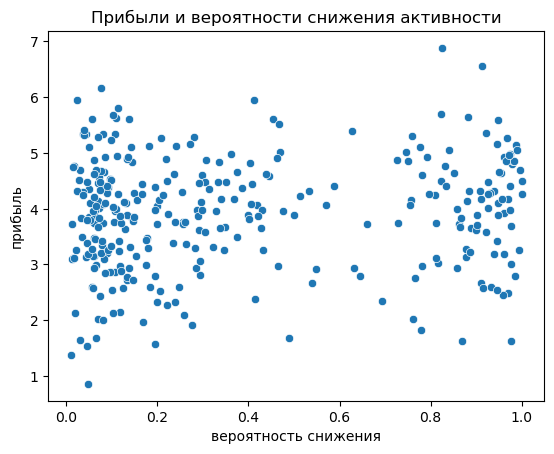

In [117]:
sns.scatterplot(x="вероятность снижения", y="прибыль", data=result)
plt.title("Прибыли и вероятности снижения активности")
plt.show()

Как видно из графика распределение делится на 2 категории примерно до 0.6 и больше 0.6. Будем разделять клиентов на эти критерии.

In [118]:
result.describe()

,id,предпредыдущий_месяц,предыдущий_месяц,текущий_месяц,маркет_актив_6_мес,маркет_актив_тек_мес,акционные_покупки,страниц_за_визит,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,предыдущий_время,текущий_время,длительность,вероятность снижения,прибыль
count,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000
mean,216003.197531,4826.731445,4924.632812,5234.353516,4.216049,3.962963,0.327099,8.145062,3.330247,2.734568,4.157407,13.243827,13.030864,590.969136,0.386057,3.907438
std,388.857258,315.802277,705.928467,815.697937,1.048302,0.662006,0.254989,4.057704,1.380608,1.810849,1.986777,3.946130,4.373326,243.995011,0.344585,0.997418
min,215349.000000,4138.000000,2960.000000,2952.199951,0.900000,3.000000,0.110000,1.000000,1.000000,0.000000,0.000000,5.000000,4.000000,129.000000,0.009796,0.860000
25%,215653.500000,4595.000000,4481.125000,4733.975098,3.800000,4.000000,0.170000,5.000000,2.000000,1.000000,3.000000,10.000000,10.000000,407.000000,0.088137,3.242500
50%,216024.500000,4794.500000,4997.250000,5213.250000,4.200000,4.000000,0.240000,8.000000,3.000000,3.000000,4.000000,13.000000,13.000000,594.500000,0.244748,3.980000
75%,216342.500000,5024.250000,5418.375000,5775.774902,4.900000,4.000000,0.310000,11.000000,4.000000,4.000000,6.000000,16.000000,16.000000,786.000000,0.769141,4.585000
max,216646.000000,5624.000000,6658.500000,7370.600098,6.600000,5.000000,0.990000,20.000000,6.000000,10.000000,9.000000,22.000000,23.000000,1061.000000,0.999998,6.880000


Также немаловажный критерий это прибыль. Думаю нужно поделить клиентов на тех кто приносит прибыль больше 4-х и меньше 4-х.

В итоге нужно поделить 3 категории людей:
1. Остаются с высокой прибылью (A) это те клиенты, что будут приносить прибыли и останутся. Вероятность снижения меньше 0,6 и прибыль больше 4.
2. Уйдут с высокой прибылью (B) те клиенты, что приносят высокую прибыль и собираются уйти (наша целевая аудитория). Вероятность снижения больше 0,6 и прибыль больше 4.
3. Остальные (C), т.е. клиенты приносящие небольшую прибыль. Данных клиентов не буду разбивать на катерогию уйдут или не уйдут, т.к. для компании наиболее важна прибыль.

In [119]:
def category(row):
    if row['прибыль'] > 4  and row['вероятность снижения'] < 0.6:
        return 'A'
    elif row['прибыль'] > 4 and row['вероятность снижения'] > 0.6:
        return 'B'
    else:
        return 'C'

In [120]:
result['категория_клиента'] = result.apply(category, axis=1)
result.head(10)

,id,тип сервиса,популярная_категория,разрешить сообщать,предпредыдущий_месяц,предыдущий_месяц,текущий_месяц,маркет_актив_6_мес,маркет_актив_тек_мес,акционные_покупки,...,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,предыдущий_время,текущий_время,длительность,акция,вероятность снижения,прибыль,категория_клиента
0,216161,стандарт,Техника для красоты и здоровья,да,4912.0,3973.0,3289.199951,4.1,4,0.15,...,6,1,4,16,17,606,False,0.029930,4.69,A
1,215654,премиум,Товары для детей,нет,4656.0,3548.0,4170.700195,1.4,4,0.94,...,3,6,1,11,9,684,True,0.766725,2.75,C
2,216307,премиум,Домашний текстиль,да,4565.0,5444.0,6335.799805,3.3,4,0.13,...,4,2,8,20,11,488,False,0.060479,3.16,C
3,215501,премиум,Домашний текстиль,да,4993.0,6604.0,6758.700195,3.5,3,0.35,...,4,3,5,9,9,1057,False,0.810852,3.74,C
4,215934,стандарт,Мелкая бытовая техника и электроника,нет,4451.0,5090.0,5773.799805,5.5,4,0.99,...,1,2,3,15,18,147,True,0.586864,4.40,A
5,216576,стандарт,Домашний текстиль,да,5150.0,4334.0,3756.800049,5.8,4,0.28,...,6,2,4,18,15,176,False,0.090204,3.20,C
6,216465,стандарт,Мелкая бытовая техника и электроника,да,5180.0,5505.5,5917.600098,4.9,4,0.17,...,5,1,4,18,15,739,False,0.070207,2.03,C
7,216527,стандарт,Техника для красоты и здоровья,нет,5023.0,4668.0,5106.100098,4.9,3,0.15,...,4,1,1,12,19,679,False,0.022122,3.26,C
8,215885,стандарт,Косметика и аксесуары,да,5326.0,5150.5,5128.399902,5.5,4,0.16,...,3,3,7,13,14,625,False,0.399318,3.89,C
9,216219,премиум,Косметика и аксесуары,да,5614.0,5198.5,4968.399902,4.1,3,0.23,...,2,1,6,13,20,784,False,0.256436,3.77,C


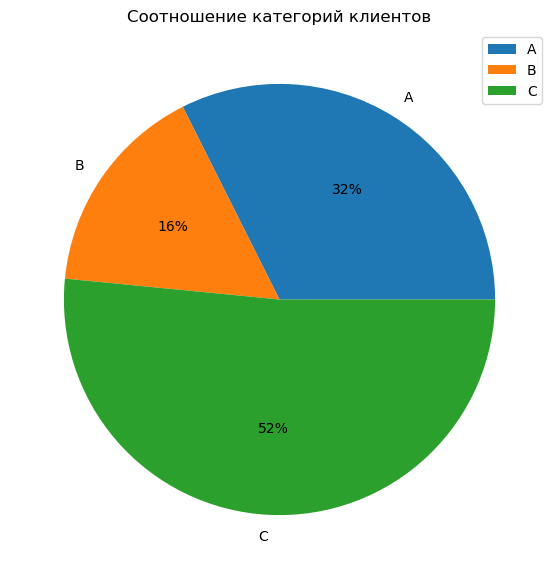

In [121]:
result.pivot_table(index='категория_клиента',values='id',aggfunc='count') \
  .plot.pie(y='id', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Соотношение категорий клиентов")
plt.show()

Искомая группа составляет 16 % от выборки. Довольно немаленький процент клиентов приносящий хорошую прибыль, стал меньше приобретать товаров. Думаю непосредственно с этими клиентами стоит провести работу.

In [122]:
category_b = result.query("категория_клиента == 'B'")
category_b

,id,тип сервиса,популярная_категория,разрешить сообщать,предпредыдущий_месяц,предыдущий_месяц,текущий_месяц,маркет_актив_6_мес,маркет_актив_тек_мес,акционные_покупки,...,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,предыдущий_время,текущий_время,длительность,акция,вероятность снижения,прибыль,категория_клиента
12,215375,премиум,Товары для детей,да,4715.0,5253.5,5633.100098,3.0,4,0.89,...,3,3,7,8,9,558,True,0.910864,4.18,B
18,215452,стандарт,Товары для детей,да,4963.0,4045.0,4206.200195,3.8,4,0.90,...,2,3,6,11,10,756,True,0.822244,4.50,B
21,215484,премиум,Товары для детей,нет,4267.0,5059.0,5018.700195,2.9,5,0.23,...,4,2,6,5,7,448,False,0.881982,5.64,B
38,215496,премиум,Техника для красоты и здоровья,да,4896.0,5020.0,5237.100098,4.0,4,0.40,...,1,6,2,11,11,684,False,0.955585,4.64,B
47,215666,стандарт,Товары для детей,да,4138.0,4945.0,5150.399902,3.5,5,0.22,...,2,2,8,6,10,703,False,0.925488,4.02,B
48,215737,стандарт,Косметика и аксесуары,да,4679.0,5126.0,5291.100098,0.9,4,0.36,...,2,4,2,9,10,225,False,0.977893,4.80,B
52,215390,стандарт,Косметика и аксесуары,да,4549.0,4254.0,4612.799805,3.1,4,0.33,...,6,4,2,8,12,152,False,0.823361,5.70,B
55,215604,стандарт,Косметика и аксесуары,нет,4308.0,4449.0,4459.399902,3.1,5,0.99,...,1,5,3,8,10,458,True,0.980975,4.86,B
60,215628,стандарт,Товары для детей,да,4566.0,3783.0,3848.000000,4.0,4,0.93,...,3,5,2,9,10,618,True,0.948499,4.11,B
62,215565,стандарт,Кухонная посуда,нет,4492.0,4657.0,5104.200195,2.4,4,0.99,...,2,5,4,11,12,522,True,0.938162,4.32,B


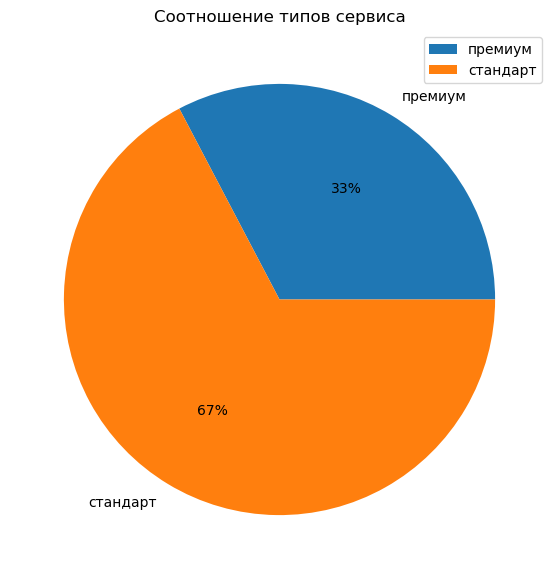

In [123]:
category_b.pivot_table(index='тип сервиса',values='id',aggfunc='count') \
  .plot.pie(y='id', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Соотношение типов сервиса")
plt.show()

Всего треть клиентов имеет подписку стандарт. Как вариант привлечения клиентов предложить им пробную подписку премиум на месяц.

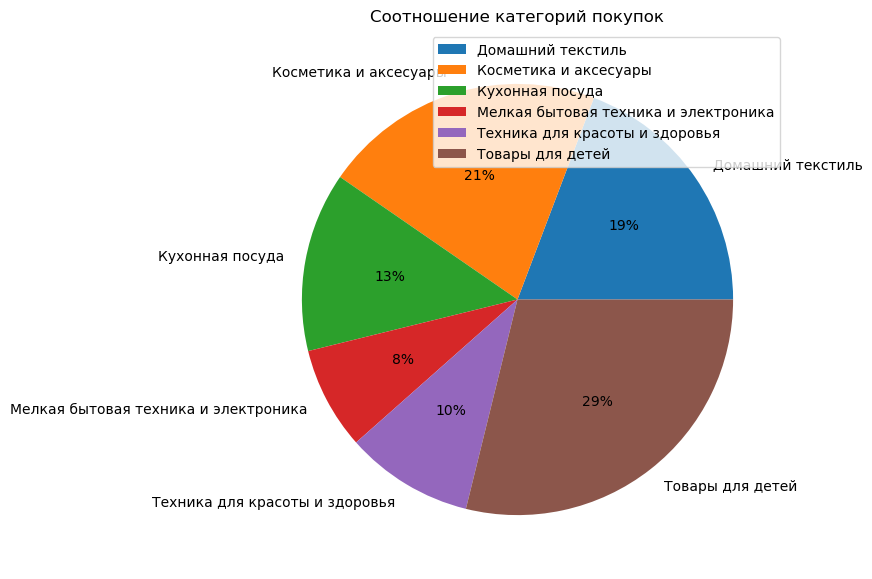

In [124]:
category_b.pivot_table(index='популярная_категория',values='id',aggfunc='count') \
  .plot.pie(y='id', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Соотношение категорий покупок")
plt.show()

Наибольший процент у них занимает категория для детей. Возможно стоит расширить эту категорию товаров. 

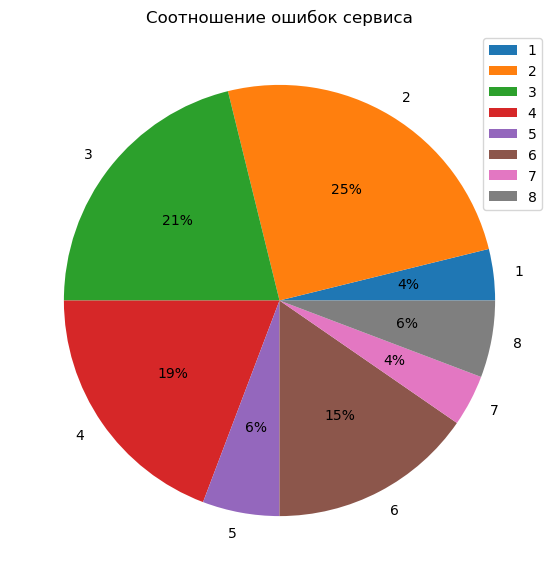

In [125]:
category_b.pivot_table(index='ошибка_сервиса',values='id',aggfunc='count') \
  .plot.pie(y='id', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Соотношение ошибок сервиса")
plt.show()

Как видно из графика, что наибольшее количество ошибок это 2 или 3, но также преобладают 4 ошибки. А также 6 ошибок, думаю этот фактор очень сильно влияет на клиентов. Ведь если ты пытаешься что-то найти на сайте, а тебе выходит ошибка, то наверняка ты сделаешь еще 1 попытку купить, кто то все же пытается и 3 и 4 раз. Стоит обратить на это внимание и провести работу с ошибками сервиса.

В сегментации мы выделили 3 тика клиентов:
1. Остаются с высокой прибылью (A) это те клиенты, что будут приносить прибыли и останутся. Вероятность снижения меньше 0,6 и прибыль больше 4.
2. Уйдут с высокой прибылью (B) те клиенты, что приносят высокую прибыль и собираются уйти (наша целевая аудитория). Вероятность снижения больше 0,6 и прибыль больше 4.
3. Остальные (C), т.е. клиенты приносящие небольшую прибыль. Данных клиентов не буду разбивать на катерогию уйдут или не уйдут, т.к. для компании наиболее важна прибыль.

    Искомая группа составляет 16 % от выборки. Довольно немаленький процент клиентов приносящий хорошую прибыль, стал меньше приобретать товаров. Для привлечения клиентов второй группы могу предложить следующее:
    - Всего треть клиентов категории В имеет подписку стандарт. Как вариант привлечения клиентов предложить им пробную подписку премиум на месяц.
    - Наибольший процент покупок у них занимает категория для детей. Возможно стоит расширить эту категорию товаров.
    - Наибольшее количество ошибок это 2, но также преобладают 3 и 4 ошибки. А также 6 ошибок, думаю этот фактор очень сильно влияет на клиентов. Ведь если ты пытаешься что-то найти на сайте, а тебе выходит ошибка, то наверняка ты сделаешь еще 1 попытку купить, кто то все же пытается и 3 и 4 раз. Стоит обратить на это внимание и провести работу с ошибками сервиса.

## Шаг 9. Общий вывод

**По итогам работы могу сделать следующие выводы:**
1. По итогам предобработки данных можно сделать следующие выводы:
    - Явных дубликатов в предоставленных данных нет.
    - Была произведена замена тип данных на float32. Данная проблема образовалась из-за того, что данные были подготовлены некорректно, и использовалась запятая вместо точки.
2. По иследованию таблицы с данными клиентов можно сделать следующие выводы:
    - У 38 % пользователей снизилась покупательская активность. Довольно большой %, стоит задуматься над привлечением клиентов.
    - Большинство, а именно 71 % пользуются сервисом "Стандарт". Покупатели не стремятся приобрести подписку премиум.
    - 3/4 от покупателей разрешили уведомлять их, это говорит о том, что им все же интересны акции платформы.
    - 25 % занимает категория "Товары для детей", "Домашний текстиль" 19 %, "Косметика и аксессуары" 17 %. Да и остальные категории отностятся к категории быта. Могу предположить, что основной контингент пользователей это молодые женщины с детьми. Стоит подумать над расширением ассортимента для данной категории людей.
    - Распределение по категориям товаров сильно отличается, от тех у кого остался прежний уровень и у кого снизилась покупательская активность. Те у кого снизилась, преобладают товары для детей и косметтика и аксессуары. В то же время, как у покупателей с прежним уровнем немалую долю занимают категории мелкая бытоая техника и техника для красоты и здоровья.
    - Премиум у клиентов со снижением занимает 34 %, в то же время как у клиентов с прежним уровнем всего 26 %. Думаю предлагать бесплатную подписку, для клиентов со снижением активности не принесет особого результата.
    
    По данными с выручкой могу сказать, что был клиент купивший товаров на сайте более чем на 106 тыс. руб. Но при обучении даннык лиет будет создавать сильный сдвиг, поэтому этого клиента мы не будем использовать в анализе. Также были клиенты с 0 суммой. Вероятно это ошибка заполнения данных, либо отказ от покупки. Таких клиентов мы тоже не будем использовать.
   
Наибольшее количество покупателей находится на сайте от 10 до 15 минут.
    
С данными о прибыли не понятно в какой форме выражены данные. Я предполагаю что это % от выручки.
    
Наибольшее снижение активности у пользователей с 8 и 9 ошибками сервиса.
    
    Согласно тех заданию нужно использовать данные с клиентами, которые в течении 3-х месяцев делали покупки. Клиентов с пропусками я удалил.
3. Мы объединили таблицы с продажами с данными о покупателях и временем проведенном на сайте. Предварительно данные о продажах и данные о времени на сайте развернули в соответсвии с запросом техзадания.
4. В корреляционном анализе мы избавились от линейной зависимостью между покупательской активностью и количеством страниц за визит. А также разделили на 2 группы покупки по акции.
5. Наилучшая модель для наших данных SVC(C=10, degree=6, gamma=0.0001, kernel='linear', random_state=42), 'num', MinMaxScaler(). При написании последующих моделей будем использовать эти гиперпараметры. accuracy_score = 0.9
6. Наибольшее влияние на целевой признак "Покупательская активность" влияют столбцы: предъыдущий_время, средний просмотр категорий за визит, и текущий время. Думаю это можно объяснить поведением покупателя. Просто так на сайт заходить не будут, и если кто-то, что-то даже не хотел покупать, но увидит хорошую цену, то обязательно приобретет товар.
7. В сегментации мы выделили 3 тика клиентов:
    1. Остаются с высокой прибылью (A) это те клиенты, что будут приносить прибыли и останутся. Вероятность снижения меньше 0,6 и прибыль больше 4.
    2. Уйдут с высокой прибылью (B) те клиенты, что приносят высокую прибыль и собираются уйти (наша целевая аудитория). Вероятность снижения больше 0,6 и прибыль больше 4.
    3. Остальные (C), т.е. клиенты приносящие небольшую прибыль. Данных клиентов не буду разбивать на катерогию уйдут или не уйдут, т.к. для компании наиболее важна прибыль.
    Искомая группа составляет 16 % от выборки. Довольно немаленький процент клиентов приносящий хорошую прибыль, стал меньше приобретать товаров. Для привлечения клиентов второй группы могу предложить следующее:
    - Всего треть клиентов категории В имеет подписку стандарт. Как вариант привлечения клиентов предложить им пробную подписку премиум на месяц.
    - Наибольший процент покупок у них занимает категория для детей. Возможно стоит расширить эту категорию товаров.
    - Наибольшее количество ошибок это 2 или 3, но также преобладают 4 ошибки. А также 6 ошибок, думаю этот фактор очень сильно влияет на клиентов. Ведь если ты пытаешься что-то найти на сайте, а тебе выходит ошибка, то наверняка ты сделаешь еще 1 попытку купить, кто то все же пытается и 3 и 4 раз. Стоит обратить на это внимание и провести работу с ошибками сервиса.